# Tabular Q-learning 
Using the Bellman equation.

This code will learn the value of states and use that as policy to solve the environment

In [1]:
# XVFB will be launched if you run on a server
from IPython.display import HTML
import gym
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ./xvfb start
    %env DISPLAY = : 1

bash: ./xvfb: No such file or directory
env: DISPLAY=: 1


In [82]:
import gym
import numpy as np
import collections
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

### Control variables

In [83]:
ENV_NAME = 'FrozenLake-v0'
GAMMA = 0.9
TEST_EPISODES = 20

### Environment info
There is a 33% chance tha we will slip on a tile. This means that when attempting to walk from a to b, there is a 33% chance that we will slip to the left or right, relative to our target cell, and 33% chance to reach the actual target cell.

We will get reward = 1 only when we reach the goal. This means that we need at least one full episode of reaching to goal to be able to learn meaningfully.

In [84]:
env = gym.make(ENV_NAME)
print('Total actions: {}'.format(env.action_space.n))
print('Total states: {}\n'.format(env.observation_space.n))
env.reset()

for i in range(env.action_space.n):
    print('Action: {}'.format(i))
    env.step(i)
    env.render()
    print()

Total actions: 4
Total states: 16

Action: 0
  (Left)
SFFF
FHFH
FFFH
HFFG

Action: 1
  (Down)
SFFF
FHFH
FFFH
HFFG

Action: 2
  (Right)
SFFF
FHFH
FFFH
HFFG

Action: 3
  (Up)
SFFF
FHFH
FFFH
HFFG



## Agent class

In [92]:
class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        
        # This table shows the reward for going from a state to a new state with action
        self.rewards = collections.defaultdict(float)
        
        # This table shows the number of times the agent ended up in the new states when executing action in state
        self.transits = collections.defaultdict(collections.Counter)
        
        self.values = collections.defaultdict(float)
        
        
    def play_n_random_steps(self, count):
        '''
        This function is used to gather random experience from the env 
        and update the reward and transition tables
        
        parameters: 
            count: the number of random steps to take
        '''
        
        for _ in range(count):
            # Sample and perform random action
            action = self.env.action_space.sample()
            new_state, reward, is_done, _ = self.env.step(action)
            
            self.rewards[(self.state, action, new_state)] = reward
            self.transits[(self.state, action)][new_state] += 1
            
            if is_done:
                self.state = self.env.reset()
            else: 
                self.state = new_state
                
                
    def calc_action_value(self, state, action):
        '''
        This function calculates the value of the action from the state using the transits, rewards, and values table.
        it will be used for two purposes:
         - Select the best action to perform from a state
         - Calculate the new value of the state on value iteration
         
         The approximate the value of the state and action (Q(s,a) will be equal to the probability to of 
         every state, multiplied with the value of the sate)
         
         parameters:
             state: agent's state in environment
             action: agent's action in state
             
         return:
             action_value: approximate value of state and action
        '''
        
        # The key is state and action, and value is a count of experienced transitions
        target_counts = self.transits[(state, action)]
        
        # Calculate the total number of transits from this state with action
        total = sum(target_counts.values())
        action_value = 0.0
        
        #Iterate through every transit and calculate its contribution using Bellman equation
        for target_state, count in target_counts.items():
            reward = self.rewards[(state, action, target_state)]
            
            # This is the empirical probability of ending up in target_state when performing action in state
            p = (count / total)
            action_value += p * (reward + GAMMA * self.values[target_state])
            
        return action_value
    
    def select_action(self, state):
        '''
        This function uses calc_action_value to make a decision about the best action 
        to take from the given state
        parameter:
            state: state to calculate best action from
        return:
            best_action: the approximate best action to take from state
        '''
        
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if best_value == None or best_value < action_value:
                best_value = action_value
                best_action = action
                
        return best_action
    
    
    def play_episode(self, env):
        '''
        This function uses select_action to get best action from state and perform it in the provided environment.
        It is used to play test episodes, during which we don't want to mess with the state of our main environment
        used to gather random data.
        parameters:
            env: second environment used for test episodes
        return:
            total_reward: accumulated reward for the episode
        '''
        total_reward = 0.0
        
        state = env.reset()

        while True:
            action = self.select_action(state)
            new_state, reward, is_done, _ = env.step(action)
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            
            if is_done: break
            state = new_state
            
        return total_reward
    
    
    def value_iteration(self):
        '''
        This function calculates the action values using the experience data thorugh value iteration.
        Value iteration is essentially:
         1 Initialize all action values (Q) to 0
         2 For every state and action in this state, perform the calc_action_value update
         3 Repeat step 2 for som large number of steps until changes become too small
        '''
        for state in range(self.env.observation_space.n):
            # Calculate action_value for each action in state
            state_values = [self.calc_action_value(state, action) for action in range(self.env.action_space.n)]
            # Select action with highest action_value as state value 
            self.values[state] = max(state_values)
            
            
    def gen_test_movie(self, env):
        
        env.reset()
        
        env_monitor = gym.wrappers.Monitor(env, directory=ENV_NAME, force=True)

        #Why is three simulations needed for saving?!
        for _ in range(3):
            done = False
            env_monitor.reset()
            while not done:
                _, _, done, _ = env_monitor.step(env_atari.action_space.sample())

        env_atari_monitor.close()
        env_atari.close()
        
        
        
            
    def print_info(self):
        print('rewards table: (state, action, new-state) : reward)')
        print(self.rewards)
        print()
        print('transits table: (state, action) : {new-states: count})')
        print(self.transits)
        print()
        print('values table')
        print(self.values)
        print()

### Training phase

In [95]:
from IPython.display import clear_output

def show_progress(log, figsize = (12,10)):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    clear_output(True)

    plt.figure(figsize=figsize)
    plt.plot(log, label='Rewards')
    plt.legend()
    plt.grid()
    plt.ylabel('Reward')
    plt.xlabel('Iteration number')
    plt.title('Reward: {}'.format(log[-1]))
    plt.show()

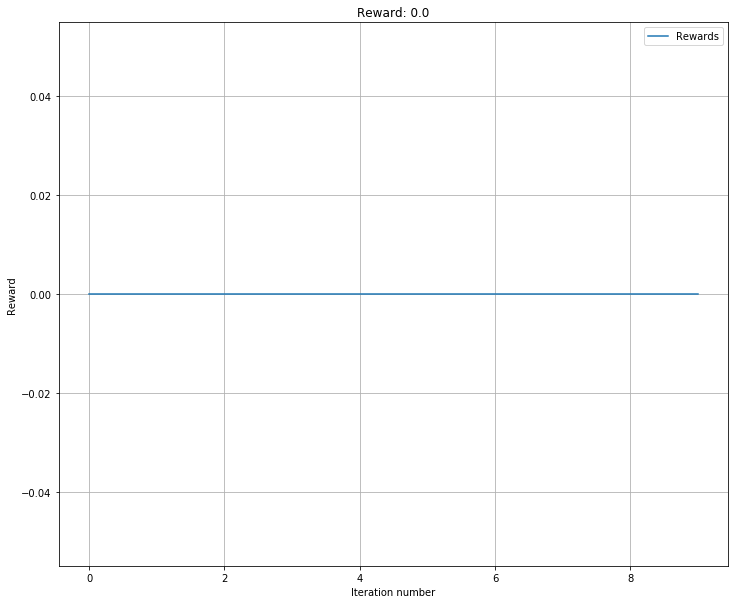

In [ ]:
test_env = gym.make(ENV_NAME)
agent = Agent()
writer = SummaryWriter(comment="-v-learning")

iter_no = 0
best_reward = 0.0
reward_log = []

'''
First, we perform 100 random steps to fill our reward and transition tables with 
fresh data and then we eun value iteration over all states. Then we play test episodes
using the value table as policy.
'''

while True:
    iter_no += 1
    agent.play_n_random_steps(100)
    agent.value_iteration()
    
    reward = 0.0
    for _ in range(TEST_EPISODES):
        reward += agent.play_episode(test_env)
    reward /= TEST_EPISODES
    writer.add_scalar("reward", reward, iter_no)
    reward_log.append(reward)
    
    show_progress(reward_log)
    
    if reward > best_reward:
        print('best reward updated: {}'.format(reward))
        best_reward = reward
    
    if reward > 0.8:
        print('Solved in {} iterations'.format(iter_no))
        break
        
writer.close()